# DDoS Classification Model

### Jeison Robles Arias

#### Project Goals

The purpose of this notebook is to investigate and recognize important patterns that could be implicated when preventing Distributed Denied of Service in Cybersecurity.

## LIBRARIES

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ipaddress

from sklearn.model_selection import train_test_split                               # for splitting the data set
from sklearn.naive_bayes import GaussianNB                                         # building the model
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [3]:
!pip install imblearn

___

## DATA LOADING

In [5]:
path = r'C:\Users\tan\Documents\final_dataset'

In [7]:
data.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,18.219.193.20,37882,172.31.69.25,80,6,16/02/2018 11:27:29 PM,8660,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,172.31.69.28,80,18.219.9.1,63287,6,22/02/2018 12:13:52 AM,5829,4,3,935.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,52.14.136.135,63095,172.31.69.28,80,6,22/02/2018 12:14:02 AM,3396,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,18.216.200.189,52341,172.31.69.28,80,6,22/02/2018 12:28:04 AM,2390,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,172.31.69.28,80,18.218.55.126,57459,6,22/02/2018 12:19:45 AM,17362,4,3,935.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616509 entries, 0 to 7616508
Data columns (total 83 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Src IP             object 
 1   Src Port           int64  
 2   Dst IP             object 
 3   Dst Port           int64  
 4   Protocol           int64  
 5   Timestamp          object 
 6   Flow Duration      int64  
 7   Tot Fwd Pkts       int64  
 8   Tot Bwd Pkts       int64  
 9   TotLen Fwd Pkts    float64
 10  TotLen Bwd Pkts    float64
 11  Fwd Pkt Len Max    float64
 12  Fwd Pkt Len Min    float64
 13  Fwd Pkt Len Mean   float64
 14  Fwd Pkt Len Std    float64
 15  Bwd Pkt Len Max    float64
 16  Bwd Pkt Len Min    float64
 17  Bwd Pkt Len Mean   float64
 18  Bwd Pkt Len Std    float64
 19  Flow Byts/s        float64
 20  Flow Pkts/s        float64
 21  Flow IAT Mean      float64
 22  Flow IAT Std       float64
 23  Flow IAT Max       float64
 24  Flow IAT Min       float64
 25  Fwd IAT Tot       

___

## FEATURE ENGINEERING

In [19]:
data['Src IP'] = data['Src IP'].apply(lambda x : int(ipaddress.IPv4Address(x)))
data['Dst IP'] = data['Dst IP'].apply(lambda x : int(ipaddress.IPv4Address(x)))

Label values:
Benign    6321980
ddos      1294529
Name: Label, dtype: int64
Bening: 0.830 
DDoS: 0.170


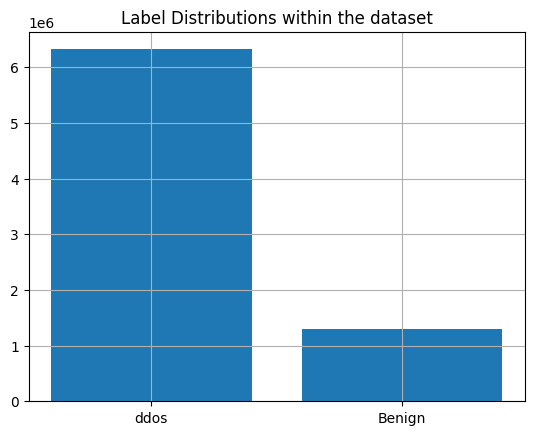

In [10]:
print('Label values:')
print(data["Label"].value_counts())
print('Bening: %.3f ' % (data["Label"].value_counts()[0] / data.shape[0]))
print('DDoS: %.3f' % (data["Label"].value_counts()[1] / data.shape[0]))

plt.bar(x=data['Label'].unique(), height=data['Label'].value_counts())
plt.title('Label Distributions within the dataset')
plt.grid()
plt.show()

## TIME INTELLIGENCE

In [11]:
#Get the entire hour to time analysis
data['Timestamp'] = pd.to_datetime(data['Timestamp']) 
data['Hour'] = data['Timestamp'].dt.hour
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['DOW'] = data['Timestamp'].dt.weekday

data.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Hour,Year,Month,Day,DOW
0,18.219.193.20,37882,172.31.69.25,80,6,2018-02-16 23:27:29,8660,1,1,0.0,...,0.0,0.0,0.0,0.0,ddos,23,2018,2,16,4
1,172.31.69.28,80,18.219.9.1,63287,6,2018-02-22 00:13:52,5829,4,3,935.0,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
2,52.14.136.135,63095,172.31.69.28,80,6,2018-02-22 00:14:02,3396,1,1,0.0,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
3,18.216.200.189,52341,172.31.69.28,80,6,2018-02-22 00:28:04,2390,1,1,0.0,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3
4,172.31.69.28,80,18.218.55.126,57459,6,2018-02-22 00:19:45,17362,4,3,935.0,...,0.0,0.0,0.0,0.0,ddos,0,2018,2,22,3


In [12]:
data['Year'].value_counts()

2018    7181780
2017     423931
2010      10798
Name: Year, dtype: int64

In [13]:
data['Month'].value_counts()

2     7181780
3      352287
4       71644
12       8887
6        1911
Name: Month, dtype: int64

<span style="background-color: yellow;
padding: 2px 5pc;
border-radius: 3px;
font-weght: bold;">Important Data

Note that in the months and years, ther are not continuity, it could means or implicate errors while data extraction from sources, or even when consolidating information in a full file

In [15]:
pivot = pd.pivot_table(data = data[data.Label == 'ddos'],
                       index=('Year','Hour'),
                       #columns=('Protocol'),
                       values = ('Protocol'),
                       aggfunc=(np.count_nonzero)
                       ).reset_index()
pivot

,Year,Hour,Protocol
0,2010,0,819
1,2010,1,158
2,2010,2,65
3,2010,3,167
4,2010,4,225
5,2010,5,188
6,2010,6,96
7,2010,7,150
8,2010,8,89
9,2010,9,660


2010
2018


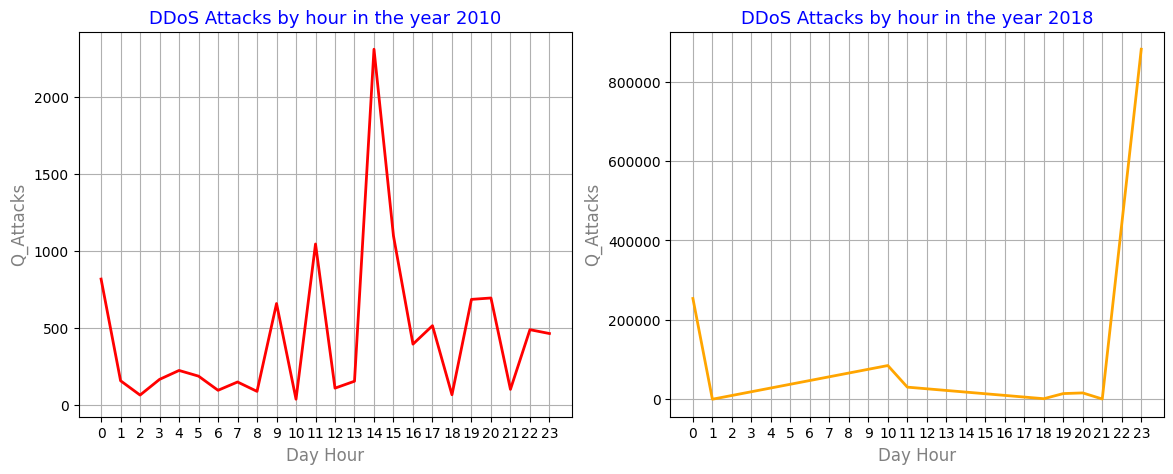

In [16]:
pivot = pd.pivot_table(data = data[data.Label == 'ddos'],
                       index=('Year','Hour'),
                       #columns=('Protocol'),
                       values = ('Protocol'),
                       aggfunc=(np.count_nonzero)
                       ).reset_index()

pivot.rename(columns={'Protocol':'Q_Attacks'}, inplace=True)

#Figure config
plt.figure(figsize=(14,5))

colors = ['red','orange','purple']
years = list(pivot['Year'].unique())
years = ['sad','ddd']

for i, year in enumerate(pivot['Year'].unique()):
    print(year)
    temp = pivot[pivot.Year == year]
    plt.subplot(1,2,i+1)
    plt.plot(temp['Hour'], temp['Q_Attacks'],linewidth =2, color = colors[i])
    plt.title('DDoS Attacks by hour in the year '+ str(year) , fontsize = 13, color = 'blue')
    plt.xlabel('Day Hour', fontsize = 12, color = 'gray')
    plt.ylabel('Q_Attacks', fontsize = 12, color = 'gray')
    plt.xticks(np.arange(24))
    plt.grid()


plt.show()


<br> Note: <br/> The attacking time was dramatically changed within 2010 and 2018

In [46]:
balance_data = data[['Flow Duration','Src IP','Src Port','Dst IP','Dst Port','Tot Fwd Pkts','Init Bwd Win Byts','Protocol','Label']]

balance_data = balance_data.astype({'Src IP':'string','Dst IP':'string','Label':'string'})

## FILTERING DATA WITH 2028 INFORMATION, BECAUSE IT HAS THE MAYORITY OF DATA

In [20]:
data_2018 =  data[data.Year == 2018]

data_2018.drop(columns=['Timestamp', 'Year','Month'], inplace=True)

print(data_2018.shape)

(7181780, 85)


## PRE PROCESING DATA

In [21]:
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181780 entries, 0 to 7616508
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Src IP             int64  
 1   Src Port           int64  
 2   Dst IP             int64  
 3   Dst Port           int64  
 4   Protocol           int64  
 5   Flow Duration      int64  
 6   Tot Fwd Pkts       int64  
 7   Tot Bwd Pkts       int64  
 8   TotLen Fwd Pkts    float64
 9   TotLen Bwd Pkts    float64
 10  Fwd Pkt Len Max    float64
 11  Fwd Pkt Len Min    float64
 12  Fwd Pkt Len Mean   float64
 13  Fwd Pkt Len Std    float64
 14  Bwd Pkt Len Max    float64
 15  Bwd Pkt Len Min    float64
 16  Bwd Pkt Len Mean   float64
 17  Bwd Pkt Len Std    float64
 18  Flow Byts/s        float64
 19  Flow Pkts/s        float64
 20  Flow IAT Mean      float64
 21  Flow IAT Std       float64
 22  Flow IAT Max       float64
 23  Flow IAT Min       float64
 24  Fwd IAT Tot        float64
 25  Fwd IAT Mean      

In [34]:
print(np.sum(data_2018.isnull().sum()))
print(np.sum(data_2018.isna().sum()))

0
0


In [38]:
le =LabelEncoder()
data_2018_Encoded = data_2018.copy()

for feature in data_2018_Encoded.keys():

    data_2018_Encoded[feature] = le.fit_transform(data_2018_Encoded[feature])


In [39]:
data_2018.dropna(inplace=True)

## FEATURE SELECTION

One can try different methods, lets use:

1. Random Forest Classifier to test 
2. Correlation Heat Map


### RANDOM UNDERSAMPLING

In [86]:
X = data_2018_Encoded.drop(columns= ('Label'))
Y = data_2018_Encoded['Label']

rus = RandomUnderSampler(sampling_strategy=1)
X_resampled, Y_resampled = rus.fit_resample(X,Y)

#smote = SMOTE(sampling_strategy='auto')
#X_resampled, y_resampled = smote.fit_resample(X,y)

In [82]:
X.shape

(7152371, 84)

In [83]:
X_resampled.shape

(2567462, 84)

In [84]:
y.value_counts()

0    5868640
1    1283731
Name: Label, dtype: int64

In [85]:
y_resampled.value_counts()

1    1283731
0    1283731
Name: Label, dtype: int64

## CORRELATION

HEATMAP

<AxesSubplot:>

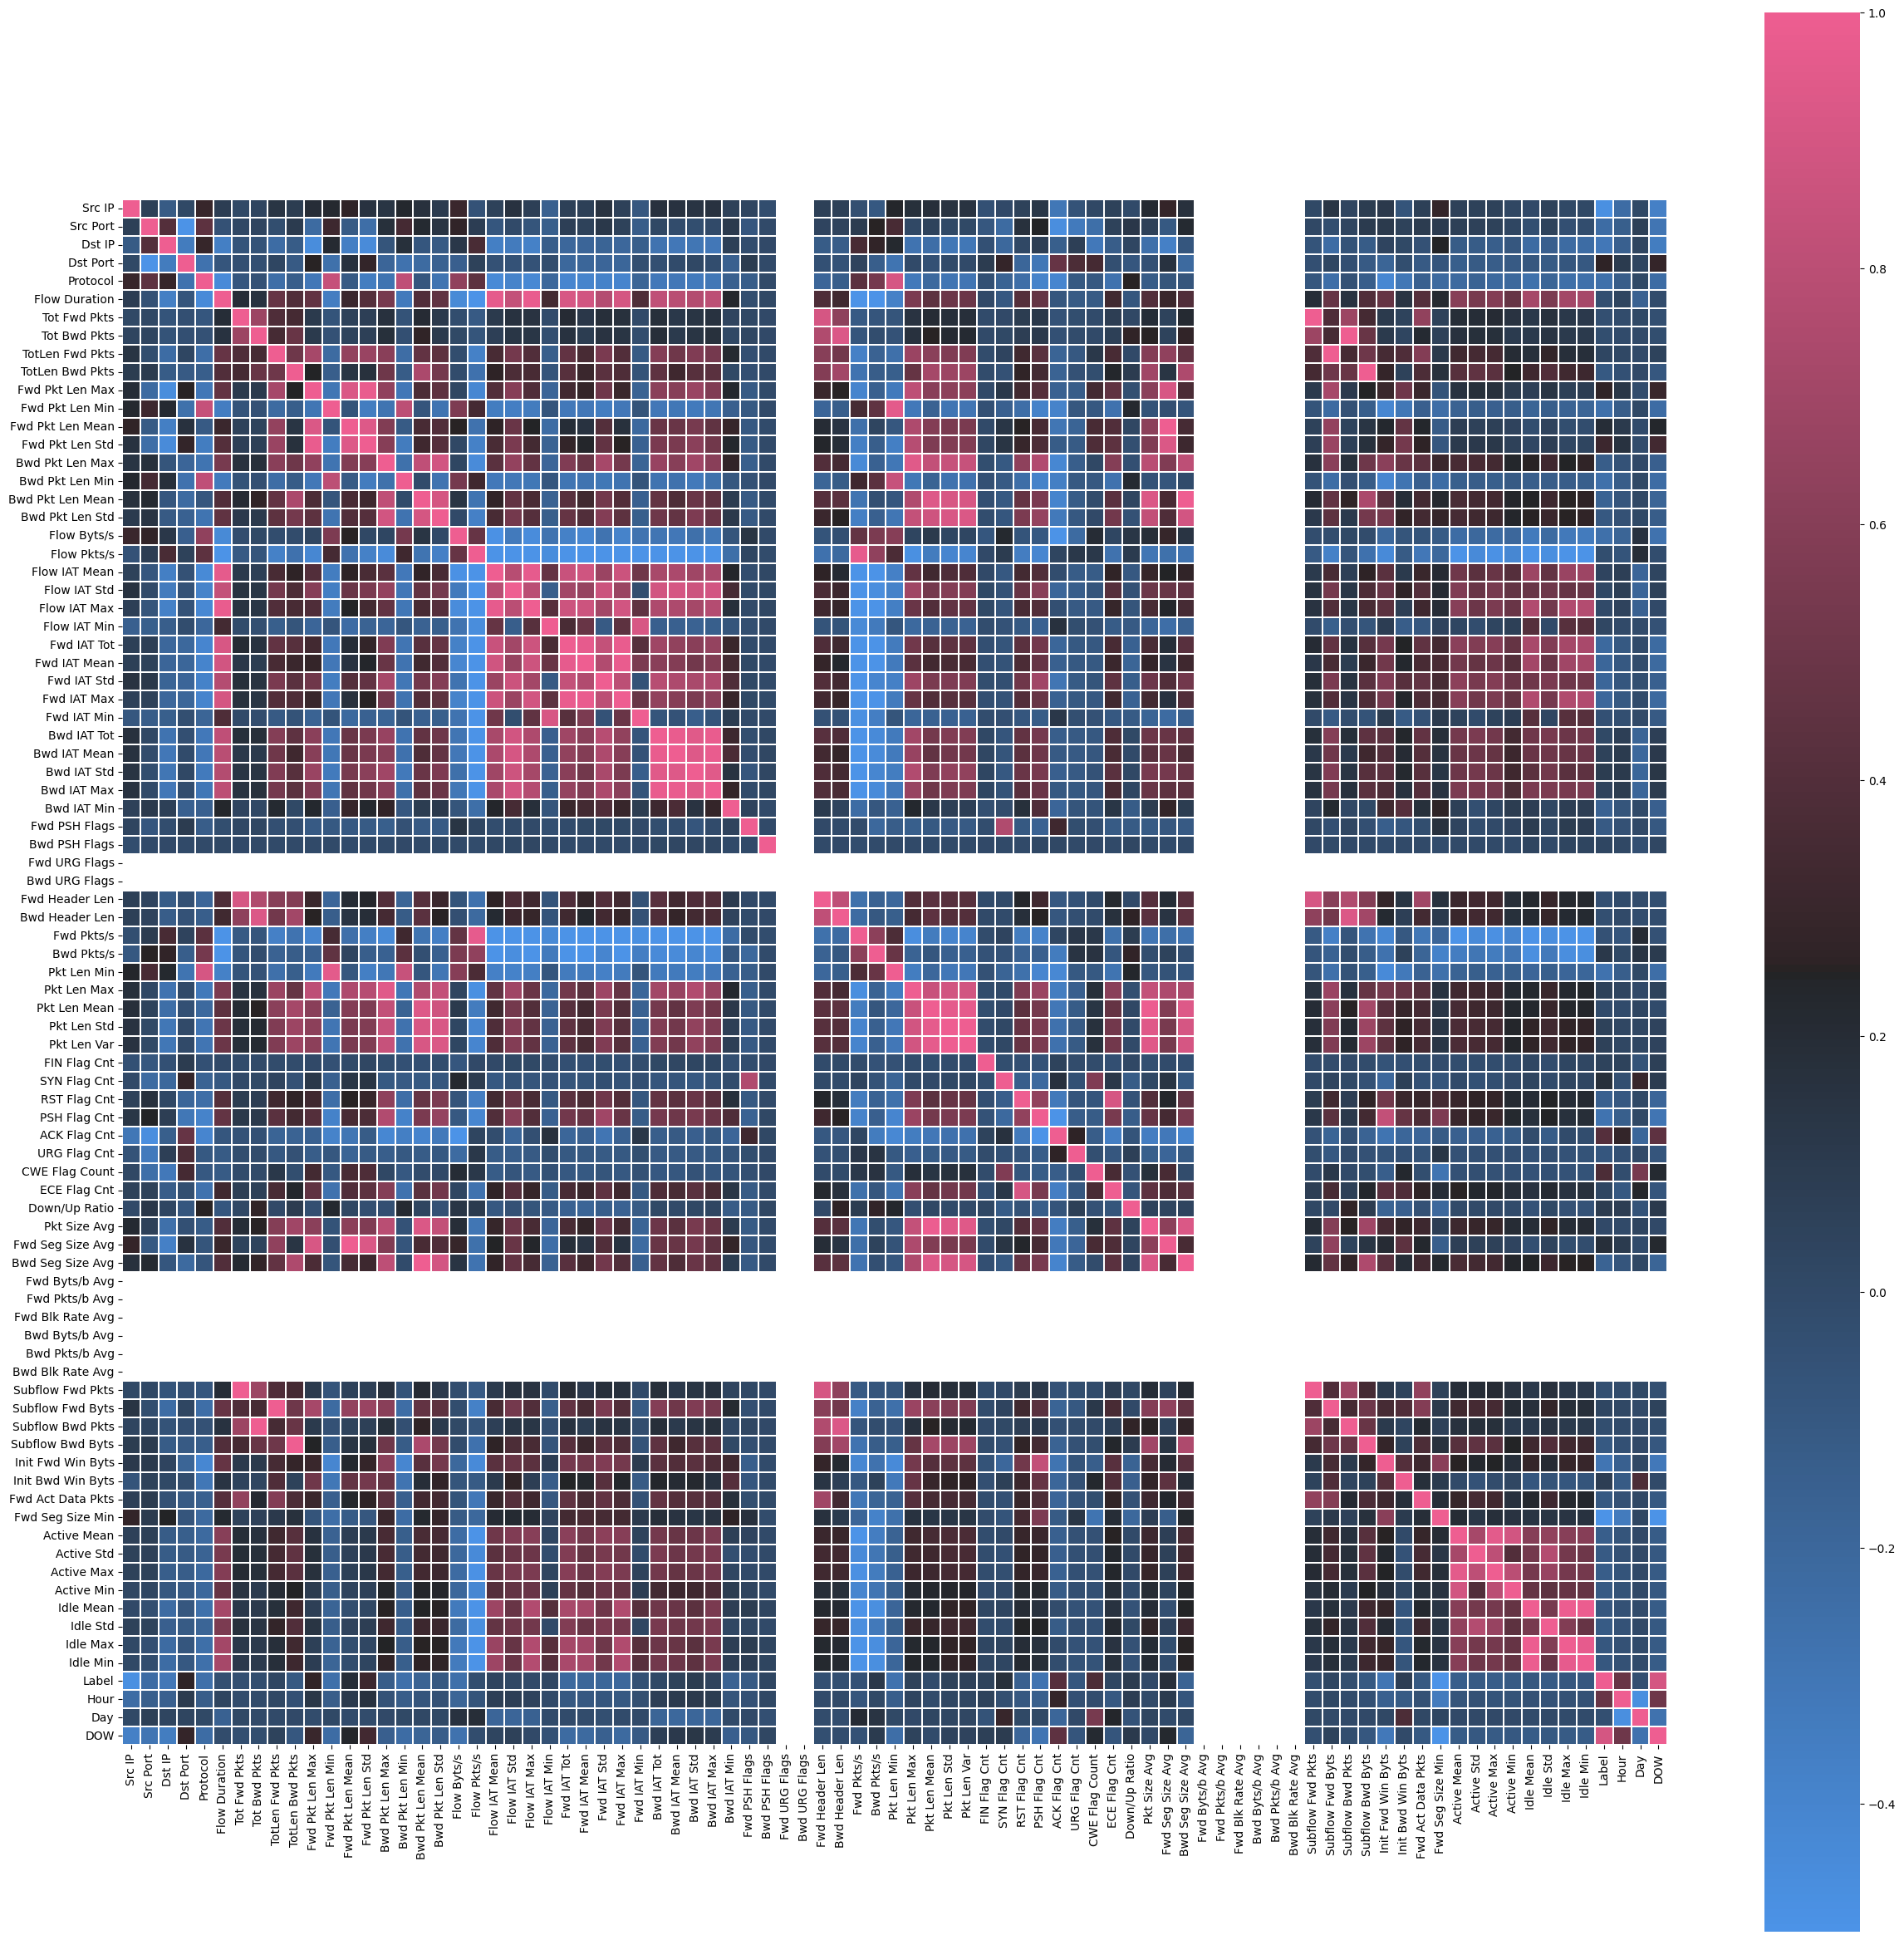

In [42]:
plt.figure(figsize=(30,30))
corr = data_2018_Encoded.corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

CORRELATION MATRIX

In [43]:
correlation_matrix = data_2018_Encoded.corr()
print(correlation_matrix)

            Src IP  Src Port    Dst IP  Dst Port  Protocol  Flow Duration  \
Src IP    1.000000  0.064667 -0.114808  0.009633  0.291313       0.083472   
Src Port  0.064667  1.000000  0.405401 -0.852818  0.438128      -0.054351   
Dst IP   -0.114808  0.405401  1.000000 -0.338358  0.290332      -0.360392   
Dst Port  0.009633 -0.852818 -0.338358  1.000000 -0.273464      -0.079777   
Protocol  0.291313  0.438128  0.290332 -0.273464  1.000000      -0.439034   
...            ...       ...       ...       ...       ...            ...   
Idle Min  0.007337 -0.024571 -0.231782 -0.097562 -0.259190       0.721626   
Label    -0.473925 -0.235139 -0.312418  0.261281 -0.259177      -0.031934   
Hour     -0.232603 -0.137734 -0.152320  0.101922 -0.128393       0.032898   
Day       0.008378  0.066250  0.028842  0.028782  0.008760      -0.154938   
DOW      -0.367477 -0.289292 -0.346654  0.281706 -0.232769      -0.017091   

          Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  ...

In [48]:
CHOOSING VARIABLES AND CREATING A DATAFRAME TO TRAIN WITH

Selected Features


['Src IP',
 'Dst IP',
 'Fwd Pkt Len Std',
 'ACK Flag Cnt',
 'CWE Flag Count',
 'Fwd Seg Size Min',
 'Label',
 'Hour',
 'DOW']

CHOOSING VARIABLES AND CREATING A DATAFRAME TO TRAIN WITH

In [50]:
data_to_train = data_2018_Encoded[selected_features]
data_to_train

,Src IP,Dst IP,Fwd Pkt Len Std,ACK Flag Cnt,CWE Flag Count,Fwd Seg Size Min,Label,Hour,DOW
0,1428,19024,0,1,0,0,1,17,3
1,20970,1334,154028,0,1,0,1,0,2
2,5666,19027,0,1,0,0,1,0,2
3,1411,19027,0,1,0,0,1,0,2
4,20970,1326,154028,0,1,0,1,0,2
...,...,...,...,...,...,...,...,...,...
7616504,28378,18917,0,1,0,2,0,5,0
7616505,20959,15248,1339,1,0,2,0,3,0
7616506,20664,18567,0,0,0,1,0,1,0
7616507,20870,18567,0,0,0,1,0,12,0


___

Text(0, 0.5, 'IP Implicated Count')

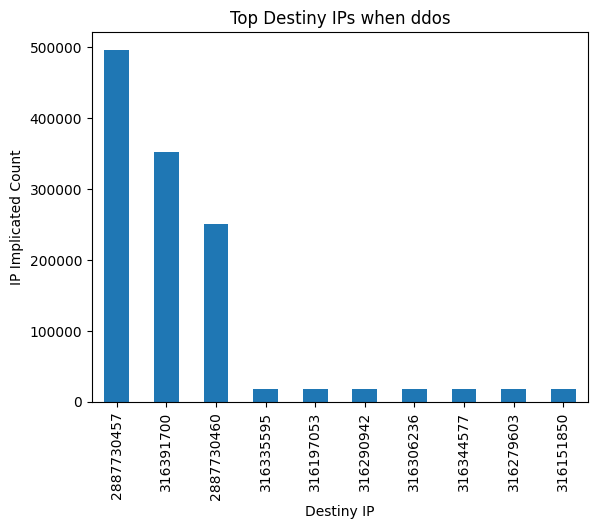

In [78]:
data_2018[data_2018.Label == 'ddos']['Dst IP'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top Destiny IPs when ddos')
plt.xlabel('Destiny IP')
plt.ylabel('IP Implicated Count')

Text(0, 0.5, 'IP Implicated Count')

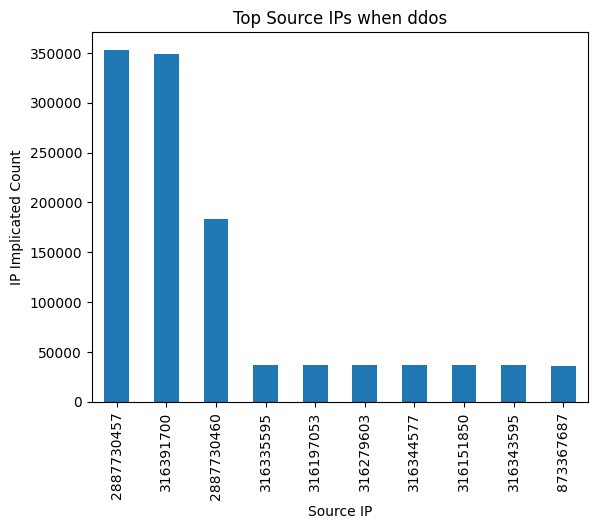

In [77]:
data_2018[data_2018.Label == 'ddos']['Src IP'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top Source IPs when ddos')
plt.xlabel('Source IP')
plt.ylabel('IP Implicated Count')

___
## Model Training

In [53]:
data_to_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7152371 entries, 0 to 7616508
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   Src IP            int64
 1   Dst IP            int64
 2   Fwd Pkt Len Std   int64
 3   ACK Flag Cnt      int64
 4   CWE Flag Count    int64
 5   Fwd Seg Size Min  int64
 6   Label             int32
 7   Hour              int64
 8   DOW               int64
dtypes: int32(1), int64(8)
memory usage: 518.4 MB


### RANDOM FOREST CLASSIFIER

In [74]:
# Separating the target variable 
X = data_to_train.drop(columns=['Label'])
Y = data_to_train['Label']

# splitting the data into test and train with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state =44)

# instantiate the model
classifier = RandomForestClassifier()

# fit the model
classifier.fit(X_train, y_train)

# predict train result
y_pred_train = classifier.predict(X_train)

y_pred_train

# predict test result
y_pred_test = classifier.predict(X_test)

y_pred_test

# accuracy score for the test and train models
print('Training-set accuracy score: {0:0.4f}%'. format(accuracy_score(y_train, y_pred_train)*100))
print('Model accuracy score: {0:0.4f}%'. format(accuracy_score(y_test, y_pred_test)*100))

Training-set accuracy score: 100.0000%
Model accuracy score: 100.0000%


___ 
### USING CROSS VALIDATION TO MORE CONFIDENCE ON MODEL ACCURACY

In [76]:
model = RandomForestClassifier()
cv_scores = cross_val_score(model, X, Y, cv=3)

print('Cross Validation Scores: ' , list( map(lambda x : round(x, 4) ,cv_scores)))

print('Mean Accuracy %.3f' % np.mean(cv_scores))
print('Standard Deviation Accuracy %.3f' % np.std(cv_scores))


y_pred = cross_val_predict(model,X,Y,cv=3)

Cross Validation Scores:  [1.0, 1.0, 1.0]
Mean Accuracy 1.000
Standard Deviation Accuracy 0.000


### GAUSIAN NB

In [52]:
# Separating the target variable 
X = data_to_train.drop(columns=['Label'])
Y = data_to_train['Label']

# splitting the data into test and train with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state =44)

# instantiate the model
classifier = GaussianNB()

# fit the model
classifier.fit(X_train, y_train)

# predict train result
y_pred_train = classifier.predict(X_train)

y_pred_train

# predict test result
y_pred_test = classifier.predict(X_test)

y_pred_test

# accuracy score for the test and train models
print('Training-set accuracy score: {0:0.4f}%'. format(accuracy_score(y_train, y_pred_train)*100))
print('Model accuracy score: {0:0.4f}%'. format(accuracy_score(y_test, y_pred_test)*100))

Training-set accuracy score: 95.6498%
Model accuracy score: 95.6789%


___ 
### USING CROSS VALIDATION TO MORE CONFIDENCE ON MODEL ACCURACY

In [69]:
model = GaussianNB()
cv_scores = cross_val_score(model, X, Y, cv=10)

print('Cross Validation Scores: ' , list( map(lambda x : round(x, 4) ,cv_scores)))

print('Mean Accuracy %.3f' % np.mean(cv_scores))
print('Standard Deviation Accuracy %.3f' % np.std(cv_scores))


y_pred = cross_val_predict(model,X,Y,cv=10)


Cross Validation Scores:  [0.9566, 0.9564, 0.9569, 0.9568, 0.9568, 0.9566, 0.9565, 0.9566, 0.9568, 0.9567]
Mean Accuracy 0.957
Standard Deviation Accuracy 0.000


### CONFUSION MATRIX 

In [70]:
CONF_MATRIX = confusion_matrix(Y,y_pred)
print('Confusion Matrix: \n', CONF_MATRIX)

Confusion Matrix: 
 [[5686876  181764]
 [ 128120 1155611]]


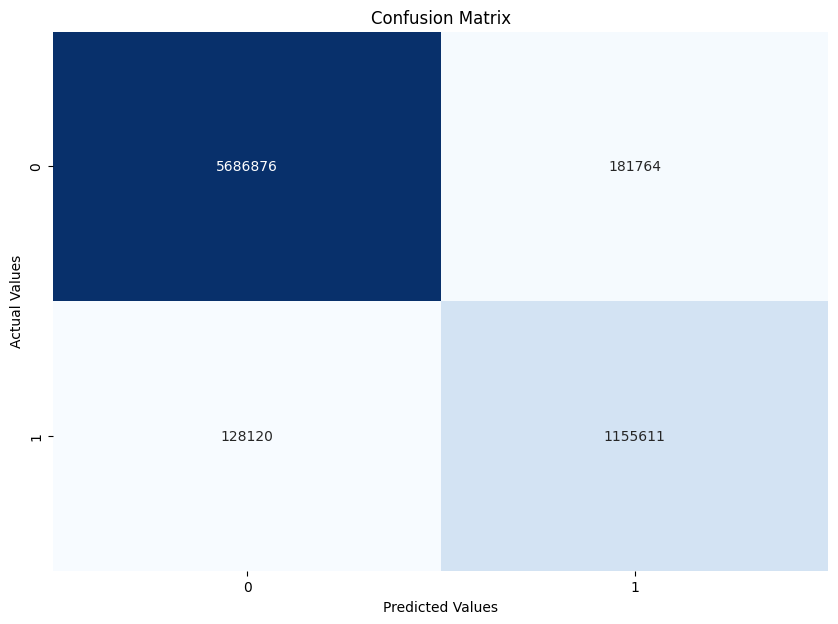

In [73]:
plt.figure(figsize=(10,7))
sns.heatmap(CONF_MATRIX, annot=True, fmt = 'd', cmap='Blues', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()